**The purpose of this notebook is to visualize the distribution of prediction errors (or deviations) in u, h, and B for a set of trials. It assumes that the prediction errors (or deviations) are organized into numpy arrays with a specific format. If you haven't already processed individual trial results for the parameter setting you are probing, use 'trial_processing.ipynb' first.**

**We also provide code for running k-means clustering in log-space, and viewing the average and standard deviation of low- and high-error cluster errors as a function of gamma for different noise levels. We also provide examples of plots of **

In [1]:
from matplotlib import pyplot as plt
from scipy.io import loadmat
import tensorflow as tf
import sys
import time
from pathlib import Path
import math as m
from tqdm import tqdm
from sklearn.cluster import KMeans
import numpy as np

In [4]:
# Set parameters
spy = 60 * 60 * 24 * 365.25
rhoi = 910.
rhow = 1028.
delta = 1. - rhoi / rhow
g = 9.81
a = 0.3 / spy
Q0 = 4.0e5 / spy
H0 = 1.0e3
B0 = 1.4688e8
n = 3

# Set scalings
Z0 = a ** (1/(n+1)) * (4 * B0) ** (n / (n + 1)) / (rhoi * g * delta) ** (n/(n + 1))
U0 = 400 / spy
Lx = U0 * Z0 / a
h0 = H0 / Z0; q0 = Q0 / (U0 * Z0)
nu_star = (2 * B0) / ( rhoi * g * delta * Z0) * (U0 / Lx) ** (1 / n)
A0 = (a * Lx) / (U0 * Z0)

#analytic h (thickness solution for constant B(x) profile)
def analytic_h_constantB(x):
    return ((A0 * h0 ** (n + 1) * (A0 * x + q0) ** (n + 1)) / (
            A0 * q0 ** (n + 1) - (q0 * h0) ** (n + 1) + (h0 * (A0 * x + q0)) ** (n + 1))) ** (1 / (n + 1))

#analytic u (velocity solution for constant B(x) profile)
def analytic_u_constantB(x):
    return (A0 * x + q0) / analytic_h_constantB(x)

x_star = np.linspace(start = 0.0, stop = 1.0, num = 401)

def compute_uerr(u_pred):
    return np.mean(np.square(u_pred-analytic_u_constantB(x_star)))

def compute_herr(h_pred):
    return np.mean(np.square(h_pred-analytic_h_constantB(x_star)))

#define tested gammas as strings for convenient plotting.
legend_gammas = np.array(['$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$', 
                 '$10^{1}$', '$10^{2}$', '$10^{3}$', '$10^{4}$', '$10^{5}$',
                 '$10^{6}$', '$10^{7}$','$10^{8}$' ])



In [3]:
# input arguments: numpy array of errors, single gamma index  for overlaying good solutions (typically optimal gamma)
#if good_indices argument is set to "True", the function will return arrays of indices of the trials in low-error clusters (gi) 
#and high-error clusters (bi).
#this is useful for visualizing all low-error accuracy predictive profiles at once.
#if good_indices argument is set to "False, it will not return the good indices"

#returns:
#low: low error cluster average
#low_std: low error cluster std
#high: high error cluster average
#high_std: high error cluster std
#ic_distance: intercluster distance --> distance between the two means found by k-means algorithm
#low_count: count of low error clusters
#err_centers: centers of the k-mean clusters
#gi: good indices
#bi: bad indices

def cluster_statistics(errors, opt_g=6, good_indices = False):
    low = np.zeros(shape = (13,3), dtype = float) #low-error cluster averages
    low_std = np.zeros(shape = (13,3), dtype = float) #low-error cluster std
    high_std = np.zeros(shape = (13,3), dtype = float) #high-error cluster std

    high = np.zeros(shape = (13,3), dtype = float) #high-error cluster averages
    low_count = np.zeros(shape=13, dtype=int)
    err_centers = np.zeros(shape = (13,2,3))

    for gamma in range(13):
        kmeans = KMeans(n_clusters=2).fit(np.log10(errors[gamma]).T)
        centers = kmeans.cluster_centers_
        err_centers[gamma][0] = centers[0]
        err_centers[gamma][1] = centers[1]

        zeros = np.argwhere(kmeans.labels_==0)
        ones = np.argwhere(kmeans.labels_==1)
        if centers[0][2] < centers[1][2]:
            low[gamma]=np.mean(errors[gamma,:,zeros], axis = 0)[0]
            low_std[gamma]=np.std(errors[gamma,:,zeros], axis = 0)[0]
            high[gamma]=np.mean(errors[gamma,:,ones], axis = 0)[0]
            high_std[gamma]=np.std(errors[gamma,:,ones], axis = 0)[0]

            low_count[gamma] = zeros.size
            err_centers[gamma][0] = centers[0]
            err_centers[gamma][1] = centers[1]


            if gamma == opt_g:
                gi = zeros.flatten()
                bi = ones.flatten()

        else:
            low[gamma]=np.mean(errors[gamma,:,ones], axis = 0)[0]
            low_std[gamma]=np.std(errors[gamma,:,ones], axis = 0)[0]
            high[gamma]=np.mean(errors[gamma,:,zeros], axis = 0)[0]
            high_std[gamma]=np.std(errors[gamma,:,zeros], axis = 0)[0]
            low_count[gamma] = ones.size
            err_centers[gamma][0] = centers[1]
            err_centers[gamma][1] = centers[0]


            if gamma == opt_g:
                gi = ones.flatten()
                bi = zeros.flatten()


    low = low.T
    low_std = low_std.T
    high = high.T
    high_std = high_std.T
    ic_distance = np.linalg.norm(np.subtract(np.power(10,err_centers[:,0,:]),np.power(10,err_centers[:,1,:])),axis = 1)
    
    if good_indices:
            return low, low_std, high, high_std, ic_distance, low_count, err_centers, gi, bi
    else:
            return low, low_std, high, high_std, ic_distance, low_count, err_centers

In [6]:
#define gamma_ratios being tested
lnratios = np.linspace(-4,8,13)
gamma_ratios = np.power(10.0, lnratios)

In [23]:
#load error numpy arrays
#c_errs = np.load('c_errs.npy')
#n01_errs = np.load('n01_errs.npy')
#n05_errs = np.load('n05_errs.npy')
#n1_errs = np.load('n1_errs.npy')
#n2_errs = np.load('n2_errs.npy')
#n3_errs = np.load('n3_errs.npy')

c_errs = np.load('ac_errs.npy')
n01_errs = np.load('an01_errs.npy')
n05_errs = np.load('an05_errs.npy')
n1_errs = np.load('an1_errs.npy')
n2_errs = np.load('an2_errs.npy')
n3_errs = np.load('an3_errs.npy')

#u20_errors=np.load('u20_errs.npy')

#u100_errors=np.load('u100_errs.npy')
#u100_average=np.average(u100_errors, axis = 2)

Text(0, 0, '(f)')

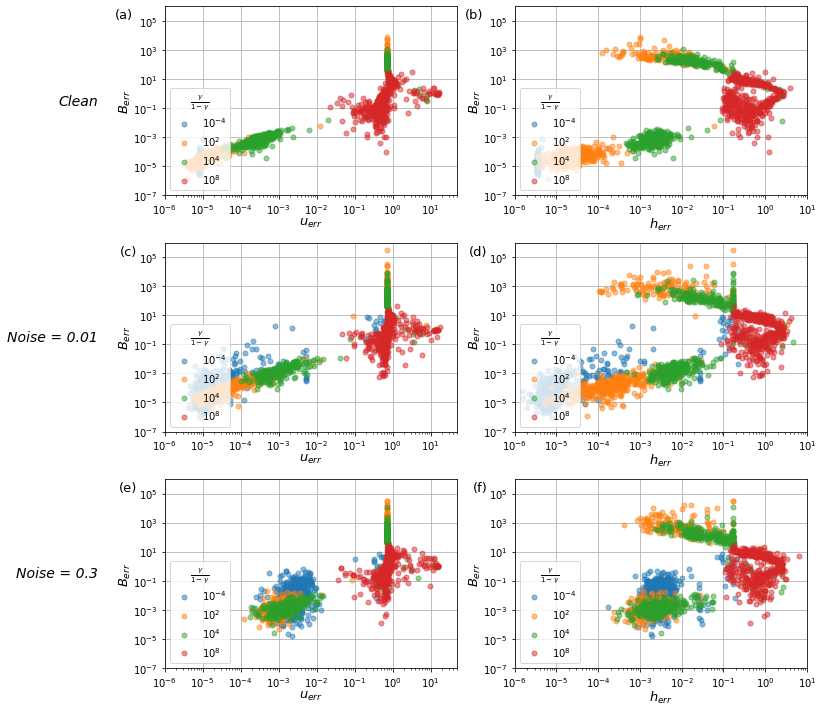

In [15]:
#Make cluster plots to visualize distribution for each noise-level gamma setting. 
#specify the indices of the gamma values to compare differences between noise levels.
indices = [0,6,8,12]
fig, ax = plt.subplots(nrows=3, ncols = 2, figsize = (10,10))
for i in indices:
    ax[0][0].loglog(c_errs[i][0], c_errs[i][2],'o', alpha = 0.5, markersize = 5)
    ax[0][1].loglog(c_errs[i][1], c_errs[i][2],'o', alpha = 0.5, markersize = 5)
    
    ax[1][0].loglog(n01_errs[i][0], n01_errs[i][2],'o', alpha = 0.5, markersize = 5)
    ax[1][1].loglog(n01_errs[i][1], n01_errs[i][2],'o', alpha = 0.5, markersize = 5)
    
    ax[2][0].loglog(n3_errs[i][0], n3_errs[i][2],'o', alpha = 0.5, markersize = 5)
    ax[2][1].loglog(n3_errs[i][1], n3_errs[i][2],'o', alpha = 0.5, markersize = 5)


for k in range(3):
    ax[k][0].set_xlabel('$u_{err}$', fontsize = 13, labelpad = 0)
    ax[k][1].set_xlabel('$h_{err}$', fontsize = 13, labelpad = 0)

for i in range(3):
    ax[i][0].set_xlim([10**(-6),5*10])
    ax[i][1].set_xlim([10**(-6),10])
    for j in range(2):
        ax[i][j].grid()
        ax[i][j].legend(legend_gammas[indices], title = '$\\frac{\gamma}{1-\gamma}$', loc = 'lower left')
        ax[i][j].set_ylabel('$B_{err}$', fontsize = 13, labelpad = 0)
        ax[i][j].set_ylim([10**(-7),10**6])
plt.tight_layout()
pad = 20
ax[0][0].annotate('Clean', xy=(0, 0.5), xycoords=ax[0][0].yaxis.label, xytext=(-ax[0][0].yaxis.labelpad - pad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='center',fontsize = 14, style = 'italic')
ax[1][0].annotate('Noise = 0.01', xy=(0, 0.5), xycoords=ax[1][0].yaxis.label, xytext=(-ax[1][0].yaxis.labelpad - pad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='center',fontsize = 14, style = 'italic')
ax[2][0].annotate('Noise = 0.3', xy=(0, 0.5), xycoords=ax[2][0].yaxis.label, xytext=(-ax[2][0].yaxis.labelpad - pad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='center',fontsize = 14, style = 'italic')

ax[0][0].annotate('(a)', xy=(1, 4.0), xycoords=ax[0][0].yaxis.label, xytext=(-ax[0][0].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='center',fontsize = 13)
ax[0][1].annotate('(b)', xy=(1, 4.0), xycoords=ax[0][1].yaxis.label, xytext=(-ax[0][1].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='center',fontsize = 13)


ax[1][0].annotate('(c)', xy=(1.3, 4.0), xycoords=ax[1][0].yaxis.label, xytext=(-ax[1][0].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='center',fontsize = 13)
ax[1][1].annotate('(d)', xy=(1.3, 4.0), xycoords=ax[1][1].yaxis.label, xytext=(-ax[1][1].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='center',fontsize = 13)

ax[2][0].annotate('(e)', xy=(1.3, 4.0), xycoords=ax[2][0].yaxis.label, xytext=(-ax[2][0].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='center',fontsize = 13)
ax[2][1].annotate('(f)', xy=(1.3, 4.0), xycoords=ax[2][1].yaxis.label, xytext=(-ax[2][1].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='center',fontsize = 13)


In [24]:
clean_low, clean_low_std, clean_high,clean_high_std, clean_ic_distance, clean_low_count, clean_err_centers=cluster_statistics(c_errs)
n01_low, n01_low_std, n01_high,u20_high_std, n01_ic_distance, n01_low_count, n01_err_centers=cluster_statistics(n01_errs)
n05_low, n05_low_std, n05_high,n05_high_std, n05_ic_distance, n05_low_count, n05_err_centers=cluster_statistics(n05_errs)
n1_low, n1_low_std, n1_high,n1_high_std, n1_ic_distance, n1_low_count, n1_err_centers=cluster_statistics(n1_errs)
n2_low, n2_low_std, n2_high,n2_high_std, n2_ic_distance, n2_low_count, n2_err_centers=cluster_statistics(n2_errs)
n3_low, n3_low_std, n3_high,n3_high_std, n3_ic_distance, n3_low_count, n3_err_centers=cluster_statistics(n3_errs)


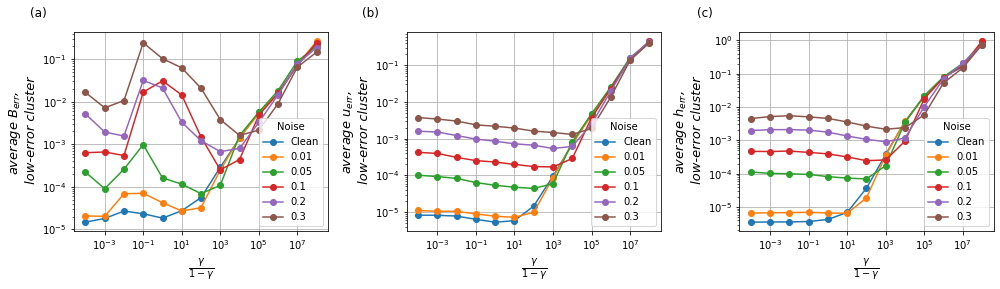

In [25]:
fig, ax = plt.subplots(nrows=1, ncols = 3, figsize = (14,4))
for i in range(3):
    ax[(i+1)%3].loglog(gamma_ratios, clean_low[i], marker ='o', label = 'Clean')
    ax[(i+1)%3].loglog(gamma_ratios, n01_low[i], marker ='o', label = '0.01')    
    ax[(i+1)%3].loglog(gamma_ratios, n05_low[i], marker ='o', label = '0.05')
    ax[(i+1)%3].loglog(gamma_ratios, n1_low[i], marker ='o', label = '0.1')
    ax[(i+1)%3].loglog(gamma_ratios, n2_low[i], marker ='o', label = '0.2')
    ax[(i+1)%3].loglog(gamma_ratios, n3_low[i], marker ='o', label = '0.3')
    ax[(i+1)%3].legend(title='Noise',loc='lower right')
    ax[(i+1)%3].set_xlabel('$\\frac{\gamma}{1-\gamma}$', fontsize = 14)
    ax[(i+1)%3].grid()

ax[0].set_ylabel('average $B_{err}$, \n low-error cluster', fontsize = 13, style='italic')
ax[1].set_ylabel('average $u_{err}$, \n low-error cluster', fontsize = 13, style='italic')
ax[2].set_ylabel('average $h_{err}$, \n low-error cluster', fontsize = 13, style='italic')
plt.tight_layout()
ax[0].annotate('(a)', xy=(1.4,1.5), xycoords=ax[0].yaxis.label, xytext=(-ax[0].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='bottom',fontsize = 12)
ax[1].annotate('(b)', xy=(1.4,1.5), xycoords=ax[1].yaxis.label, xytext=(-ax[1].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='bottom',fontsize = 12)
ax[2].annotate('(c)', xy=(1.4,1.5), xycoords=ax[2].yaxis.label, xytext=(-ax[2].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='bottom',fontsize = 12)
plt.tight_layout()

In [7]:
u20_low, u20_low_std, u20_high,u20_high_std, u20_ic_distance, u20_low_count, u20_err_centers=cluster_statistics(u20_errors)

In [8]:
u100_low, u100_low_std, u100_high, u100_high_std, u100_ic_distance, u100_low_count, u100_err_centers=cluster_statistics(u100_errors)

In [17]:
u5_low, u5_low_std, u5_high, u5_high_std, u5_ic_distance, u5_low_count, u5_err_centers=cluster_statistics(an3_errors)

Text(-4.0, 0, '(b)')

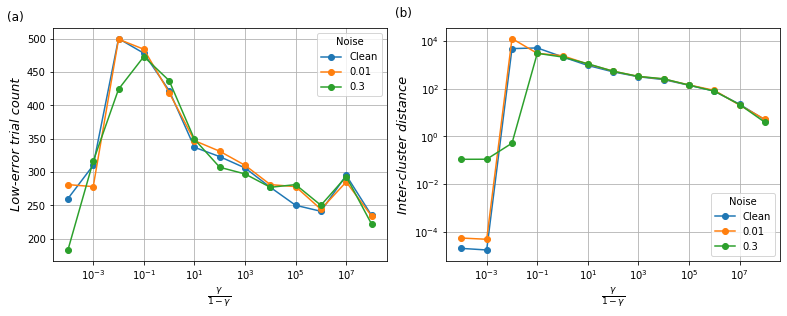

In [73]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (11,4.2))

ax[0].semilogx(gamma_ratios,adam_clean_low_count, marker='o',label='Clean')
ax[0].semilogx(gamma_ratios,adam_n01_low_count, marker='o',label='0.01')
#ax.semilogx(gamma_ratios,adam_n05_low_count,marker='o',label='0.05')
#ax.semilogx(gamma_ratios,adam_n1_low_count,marker='o',label='0.1')
#ax.semilogx(gamma_ratios,adam_n2_low_count,marker='o',label='0.2')
ax[0].semilogx(gamma_ratios,adam_n3_low_count,marker='o',label='0.3')

ax[1].loglog(gamma_ratios, clean_ic_distance, marker='o', label = 'Clean')
ax[1].loglog(gamma_ratios, n01_ic_distance, marker='o', label = '0.01')
ax[1].loglog(gamma_ratios, n3_ic_distance, marker='o', label = '0.3')


for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('$\\frac{\gamma}{1-\gamma}$', fontsize = 13)
    ax[i].legend(title='Noise')
ax[0].set_ylabel('Low-error trial count', fontsize = 13, style ='italic')
ax[1].set_ylabel('Inter-cluster distance', fontsize = 13, style ='italic')
plt.tight_layout()

ax[0].annotate('(a)', xy=(1.4,1.4), xycoords=ax[0].yaxis.label, xytext=(-ax[0].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='bottom',fontsize = 12)
ax[1].annotate('(b)', xy=(1.4,1.4), xycoords=ax[1].yaxis.label, xytext=(-ax[1].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='bottom',fontsize = 12)


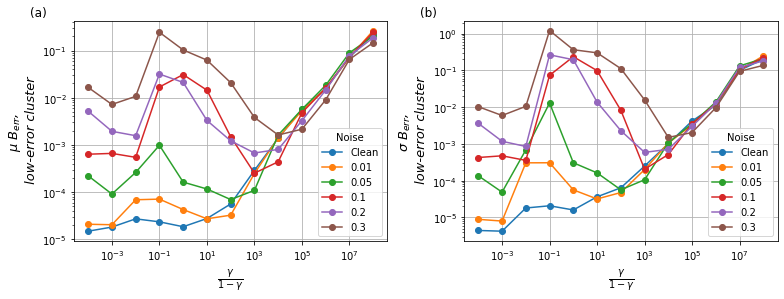

In [26]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (11,4.2))

ax[0].loglog(gamma_ratios, clean_low[2], marker ='o', label = 'Clean')
ax[0].loglog(gamma_ratios, n01_low[2], marker ='o', label = '0.01')    
ax[0].loglog(gamma_ratios, n05_low[2], marker ='o', label = '0.05')
ax[0].loglog(gamma_ratios, n1_low[2], marker ='o', label = '0.1')
ax[0].loglog(gamma_ratios, n2_low[2], marker ='o', label = '0.2')
ax[0].loglog(gamma_ratios, n3_low[2], marker ='o', label = '0.3')

ax[1].loglog(gamma_ratios, clean_low_std[2], marker ='o', label = 'Clean')
ax[1].loglog(gamma_ratios, n01_low_std[2], marker ='o', label = '0.01')    
ax[1].loglog(gamma_ratios, n05_low_std[2], marker ='o', label = '0.05')
ax[1].loglog(gamma_ratios, n1_low_std[2], marker ='o', label = '0.1')
ax[1].loglog(gamma_ratios, n2_low_std[2], marker ='o', label = '0.2')
ax[1].loglog(gamma_ratios, n3_low_std[2], marker ='o', label = '0.3')

for i in range(2):
    ax[i].set_xlabel('$\\frac{\gamma}{1-\gamma}$', fontsize = 14)
    ax[i].grid()
    ax[i].legend(title='Noise',loc='lower right')


ax[0].set_ylabel('$\mu$ $B_{err}$, \n low-error cluster', fontsize = 13, style='italic')
ax[1].set_ylabel('$\sigma$ $B_{err}$, \n low-error cluster', fontsize = 13, style='italic')
plt.tight_layout()

ax[0].annotate('(a)', xy=(1.4,1.5), xycoords=ax[0].yaxis.label, xytext=(-ax[0].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='bottom',fontsize = 12)
ax[1].annotate('(b)', xy=(1.4,1.5), xycoords=ax[1].yaxis.label, xytext=(-ax[1].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='bottom',fontsize = 12)

plt.tight_layout()

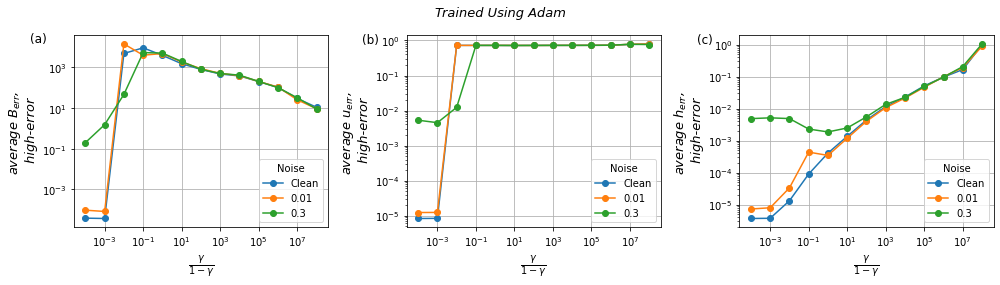

In [27]:
fig, ax = plt.subplots(nrows=1, ncols = 3, figsize = (14,4))
for i in range(3):
    ax[(i+1)%3].loglog(gamma_ratios, clean_high[i], marker ='o', label = 'Clean')
    ax[(i+1)%3].loglog(gamma_ratios, n01_high[i], marker ='o', label = '0.01')
    ax[(i+1)%3].loglog(gamma_ratios, n3_high[i], marker ='o', label = '0.3')
    ax[(i+1)%3].legend(title='Noise',loc='lower right')
    ax[(i+1)%3].set_xlabel('$\\frac{\gamma}{1-\gamma}$', fontsize = 14)
    ax[(i+1)%3].grid()

ax[0].set_ylabel('average $B_{err}$, \n high-error', fontsize = 13, style='italic')
ax[1].set_ylabel('average $u_{err}$, \n high-error', fontsize = 13, style='italic')
ax[2].set_ylabel('average $h_{err}$, \n high-error', fontsize = 13, style='italic')
plt.tight_layout()
ax[0].annotate('(a)', xy=(1.4,1.5), xycoords=ax[0].yaxis.label, xytext=(-ax[0].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='bottom',fontsize = 12)
ax[1].annotate('(b)', xy=(1.4,1.5), xycoords=ax[1].yaxis.label, xytext=(-ax[1].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='bottom',fontsize = 12)
ax[2].annotate('(c)', xy=(1.4,1.5), xycoords=ax[2].yaxis.label, xytext=(-ax[2].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='bottom',fontsize = 12)
plt.suptitle("Trained Using Adam", fontsize = 13, style ='italic')
plt.tight_layout()

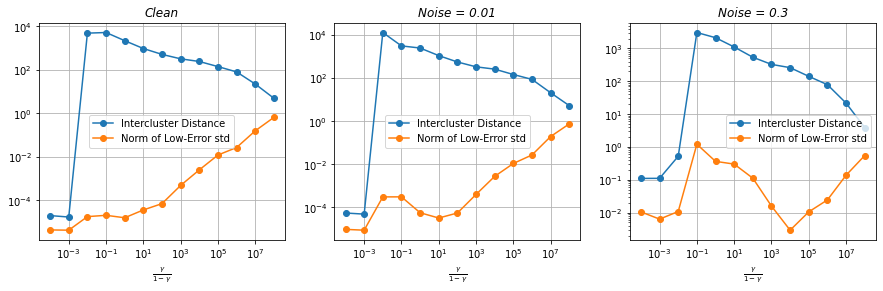

In [28]:
#ic_distance = np.linalg.norm(np.subtract(np.power(10,clean_centers[:,0,:]),np.power(10,clean_centers[:,1,:])),axis = 1)
fig, ax = plt.subplots(nrows=1, ncols = 3, figsize = (15,4))

ax[0].loglog(gamma_ratios, clean_ic_distance, marker='o', label = 'Intercluster Distance')
ax[0].loglog(gamma_ratios, np.linalg.norm(clean_low_std,axis=0), marker = 'o', label='Norm of Low-Error std' )
ax[0].set_title('Clean', style = 'italic')

ax[1].loglog(gamma_ratios, n01_ic_distance, marker='o', label = 'Intercluster Distance')
ax[1].loglog(gamma_ratios, np.linalg.norm(n01_low_std,axis=0), marker = 'o', label='Norm of Low-Error std' )
ax[1].set_title('Noise = 0.01', style = 'italic')

ax[2].loglog(gamma_ratios, n3_ic_distance, marker='o', label = 'Intercluster Distance')
ax[2].loglog(gamma_ratios, np.linalg.norm(n3_low_std,axis=0), marker = 'o', label='Norm of Low-Error std' )
ax[2].set_title('Noise = 0.3', style = 'italic')



for i in range(3):
    ax[i].set_xlabel('$\\frac{\gamma}{1-\gamma}$')
    ax[i].grid()
    ax[i].legend()
